# Random Forest regressor

In [1]:
from sklearn.ensemble import RandomForestRegressor
from utils.utils_pixel import *
from sklearn.metrics import mean_squared_error
from tqdm import tqdm
from sklearn.model_selection import GridSearchCV

import pickle
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns

/u/seleneledain/.conda/envs/drought2/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
n_timesteps_in = 9
n_timesteps_out = 1
n_feats_in = 85
n_feats_out = 1
exp = 'clean'
sample_type = 'pixel_data'
feature_set = ["MSI", "NDMI", "NDVIre", "NDWI", "B11", "B12", "B2", "B3", "B4", "B5", "B6", "B7", "B8", "B8a", "CP", "NDVI", "SCL",
               "VPDX", "VPDN", "AWVC", "MAXT", "MINT", "SR" ,"SP", "T", "TCC", "TP", 
               "DEM", 
               "CURV17", "CURV19", "CURV21", "EAST17", "EAST19", "EAST21", "NORT17", "NORT19", "NORT21", "RUGG17", "RUGG19", "RUGG21", "SLOP17", "SLOP19", "SLOP21", "TWI17", "TWI19", "TWI21",
               "CLAY0_5", "CLAY100_200", "CLAY15_30", "CLAY30_60", "CLAY5_15", "CLAY60_100",
               "FED0_5", "FED100_200", "FED15_30",  "FED30_60", "FED5_15", "FED60_100",
               "FC", "FH",
               "GRAV0_5", "GRAV100_200", "GRAV15_30", "GRAV30_60", "GRAV5_15", "GRAV60_100",
               "SAND0_5", "SAND100_200", "SAND15_30", "SAND30_60","SAND5_15", "SAND60_100",
               "SDEP",
               "CARB0_5", "CARB100_200", "CARB15_30", "CARB30_60", "CARB5_15", "CARB60_100",
               "PH0_5", "PH100_200", "PH15_30", "PH30_60","PH5_15", "PH60_100"]
remove_band = ["MSI", "NDMI", "NDVIre", "NDWI", "B11", "B12", "B2", "B3", "B4", "B5", "B6", "B7", "B8", "B8a", "SCL",
               "VPDX", "VPDN", "AWVC", "MAXT", "MINT", "SP", "TCC",
               "CURV17", "CURV19", "CURV21", "EAST17", "EAST19", "EAST21", "NORT17", "NORT19", "NORT21", "RUGG17", "RUGG19", "RUGG21", "SLOP17", "SLOP19", "SLOP21", "TWI17", "TWI19", "TWI21",
               "CLAY0_5", "CLAY100_200", "CLAY15_30", "CLAY30_60", "CLAY5_15", "CLAY60_100",
               "FED0_5", "FED100_200", "FED15_30",  "FED30_60", "FED5_15", "FED60_100",
               "FC", "FH",
               "GRAV0_5", "GRAV100_200", "GRAV15_30", "GRAV30_60", "GRAV5_15", "GRAV60_100",
               "SAND0_5", "SAND100_200", "SAND15_30", "SAND30_60","SAND5_15", "SAND60_100",
               "SDEP",
               "CARB0_5", "CARB100_200", "CARB15_30", "CARB30_60", "CARB5_15", "CARB60_100",
               "PH0_5", "PH100_200", "PH15_30", "PH30_60","PH5_15", "PH60_100"]


n_epochs = 100
n_batches = 1000
n_batches_val = 100
n_batches_te = 100
batch_size = 40

In [3]:
def get_val_metrics(rf, batch_size, n_batches_val, sample_type, exp, n_timesteps_in, n_timesteps_out, feature_set, remove_band):

    r2_tot = 0
    mse_tot = 0
    
    for batch_nbr in range(n_batches_val):
        # get the current batch of data
        X_tr = np.empty([batch_size, n_timesteps_in, len(feature_set)-len(remove_band)])
        y_tr = np.empty([batch_size, n_timesteps_out, 1])

        # Load a batch here
        img, label = load_batch(batch_size=batch_size, batch_nbr=batch_nbr, sample_type=sample_type, split='val', exp=exp, n_timesteps_out=n_timesteps_out)
        # shapes: [batch_size, n_timesteps_in, n_feats_in] and [batch_size, n_timesteps_out, n_feats_out]

        img = remove_features_batch_level(img, remove_band, feature_set)
        label = remove_features_batch_level(label, remove_band, feature_set)

        # still predict both, but dont use cp_idx for masking clouds in loss
        to_keep = 1 #NDVI only
        label = label[:,:,to_keep,:,:]

        X_tr[:, :, :] = th.reshape(img, (batch_size, img.size(dim=1), img.size(dim=2))).numpy()
        y_tr[:, :, :] = th.reshape(label, (batch_size, label.size(dim=1), label.size(dim=2))).numpy()

        # Concatenate all timesteps after each other
        X_batch = np.reshape(X_tr, (batch_size, n_timesteps_in*(len(feature_set)-len(remove_band))))
        y_batch = np.reshape(y_tr, (batch_size, n_timesteps_out*n_feats_out))
        
        r2_tot += rf.score(X_batch, y_batch)

        # calculate the MSE loss
        y_pred = rf.predict(X_batch)
        mse_tot += mean_squared_error(y_batch, y_pred)

    return r2_tot/n_batches_val, mse_tot/n_batches_val


def get_test_metrics(rf, batch_size, n_batches_te, sample_type, exp, n_timesteps_in, n_timesteps_out, feature_set, remove_band):
    
    r2_tot = 0
    mse_tot = 0
    
    for batch_nbr in range(n_batches_te):
        # get the current batch of data
        X_tr = np.empty([batch_size, n_timesteps_in, len(feature_set)-len(remove_band)])
        y_tr = np.empty([batch_size, n_timesteps_out, 1])

        # Load a batch here
        img, label = load_batch(batch_size=batch_size, batch_nbr=batch_nbr, sample_type=sample_type, split='test', exp=exp, n_timesteps_out=n_timesteps_out)
        # shapes: [batch_size, n_timesteps_in, n_feats_in] and [batch_size, n_timesteps_out, n_feats_out]

        img = remove_features_batch_level(img, remove_band, feature_set)
        label = remove_features_batch_level(label, remove_band, feature_set)

        # still predict both, but dont use cp_idx for masking clouds in loss
        to_keep = 1 #NDVI only
        label = label[:,:,to_keep,:,:]

        X_tr[:, :, :] = th.reshape(img, (batch_size, img.size(dim=1), img.size(dim=2))).numpy()
        y_tr[:, :, :] = th.reshape(label, (batch_size, label.size(dim=1), label.size(dim=2))).numpy()

        # Concatenate all timesteps after each other
        X_batch = np.reshape(X_tr, (batch_size, n_timesteps_in*(len(feature_set)-len(remove_band))))
        y_batch = np.reshape(y_tr, (batch_size, n_timesteps_out*n_feats_out))

        r2_tot += rf.score(X_batch, y_batch)

        # calculate the MSE loss
        y_pred = rf.predict(X_batch)
        mse_tot += mean_squared_error(y_batch, y_pred)
    
    return r2_tot/n_batches_te, mse_tot/n_batches_te

In [4]:
rf = RandomForestRegressor(n_estimators=200, max_depth=20)

for epoch in tqdm(range(n_epochs)):
    for batch_nbr in range(n_batches):
        # get the current batch of data
        X_tr = np.empty([batch_size, n_timesteps_in, len(feature_set)-len(remove_band)])
        y_tr = np.empty([batch_size, n_timesteps_out, 1])

        # Load a batch here 
        img, label = load_batch(batch_size=batch_size, batch_nbr=batch_nbr, sample_type=sample_type, split='train', exp=exp, n_timesteps_out=n_timesteps_out)
        # shapes: [batch_size, n_timesteps_in, n_feats_in] and [batch_size, n_timesteps_out, n_feats_out]

        img = remove_features_batch_level(img, remove_band, feature_set)
        label = remove_features_batch_level(label, remove_band, feature_set)

        # still predict both, but dont use cp_idx for masking clouds in loss
        to_keep = 1
        label = label[:,:,to_keep,:,:]

        X_tr[:, :, :] = th.reshape(img, (batch_size, img.size(dim=1), img.size(dim=2))).numpy()
        y_tr[:, :, :] = th.reshape(label, (batch_size, label.size(dim=1), label.size(dim=2))).numpy()

        # Concatenate all timesteps after each other
        X_batch = np.reshape(X_tr, (batch_size, n_timesteps_in*(len(feature_set)-len(remove_band))))
        y_batch = np.reshape(y_tr, (batch_size, n_timesteps_out*n_feats_out))

        
        # fit the regressor on the current batch
        rf.fit(X_batch, y_batch.ravel())
    
    r2, mse = get_val_metrics(rf, batch_size, n_batches_val, sample_type, exp, n_timesteps_in, n_timesteps_out, feature_set, remove_band)
    print(f'Validation metrics for epoch {epoch}: R2 {r2}. MSE {mse}.') 


  1%|█▎                                                                                                                                      | 1/100 [07:17<12:02:06, 437.64s/it]

Validation metrics for epoch 0: R2 -9.933898731488675. MSE 0.042007783951078785.


  2%|██▋                                                                                                                                     | 2/100 [14:36<11:55:48, 438.25s/it]

Validation metrics for epoch 1: R2 -11.117392233275812. MSE 0.044101923828216705.


  3%|████                                                                                                                                    | 3/100 [21:50<11:45:46, 436.56s/it]

Validation metrics for epoch 2: R2 -8.193591118591286. MSE 0.039410155775902324.


  4%|█████▍                                                                                                                                  | 4/100 [29:01<11:34:56, 434.34s/it]

Validation metrics for epoch 3: R2 -9.936652369840047. MSE 0.041975002916165946.


  5%|██████▊                                                                                                                                 | 5/100 [35:05<10:47:15, 408.80s/it]

Validation metrics for epoch 4: R2 -8.685694184397601. MSE 0.03955943751330227.


  6%|████████▏                                                                                                                                | 6/100 [40:28<9:54:44, 379.63s/it]

Validation metrics for epoch 5: R2 -9.332624178539625. MSE 0.04042296410909213.


  7%|█████████▌                                                                                                                               | 7/100 [45:48<9:18:20, 360.22s/it]

Validation metrics for epoch 6: R2 -9.541546320253168. MSE 0.040631046713893226.


  8%|██████████▉                                                                                                                              | 8/100 [51:07<8:52:06, 347.02s/it]

Validation metrics for epoch 7: R2 -8.979805563211963. MSE 0.040546872238208166.


  9%|████████████▎                                                                                                                            | 9/100 [56:27<8:33:30, 338.58s/it]

Validation metrics for epoch 8: R2 -9.239198983149633. MSE 0.04104826589051304.


 10%|█████████████▍                                                                                                                        | 10/100 [1:01:44<8:17:54, 331.94s/it]

Validation metrics for epoch 9: R2 -8.080690712532874. MSE 0.03921523007714639.


 11%|██████████████▋                                                                                                                       | 11/100 [1:07:02<8:05:57, 327.61s/it]

Validation metrics for epoch 10: R2 -10.066722523747128. MSE 0.041812191223011407.


 12%|████████████████                                                                                                                      | 12/100 [1:12:34<8:02:44, 329.14s/it]

Validation metrics for epoch 11: R2 -10.789902145781005. MSE 0.04352566042802792.


 12%|████████████████                                                                                                                      | 12/100 [1:12:41<8:53:04, 363.46s/it]


KeyboardInterrupt: 

In [4]:
rf = RandomForestRegressor()

for epoch in tqdm(range(n_epochs)):
    for batch_nbr in range(n_batches):
        # get the current batch of data
        X_tr = np.empty([batch_size, n_timesteps_in, len(feature_set)-len(remove_band)])
        y_tr = np.empty([batch_size, n_timesteps_out, 1])

        # Load a batch here 
        img, label = load_batch(batch_size=batch_size, batch_nbr=batch_nbr, sample_type=sample_type, split='train', exp=exp, n_timesteps_out=n_timesteps_out)
        # shapes: [batch_size, n_timesteps_in, n_feats_in] and [batch_size, n_timesteps_out, n_feats_out]

        img = remove_features_batch_level(img, remove_band, feature_set)
        label = remove_features_batch_level(label, remove_band, feature_set)

        # still predict both, but dont use cp_idx for masking clouds in loss
        to_keep = 1
        label = label[:,:,to_keep,:,:]

        X_tr[:, :, :] = th.reshape(img, (batch_size, img.size(dim=1), img.size(dim=2))).numpy()
        y_tr[:, :, :] = th.reshape(label, (batch_size, label.size(dim=1), label.size(dim=2))).numpy()

        # Concatenate all timesteps after each other
        X_batch = np.reshape(X_tr, (batch_size, n_timesteps_in*(len(feature_set)-len(remove_band))))
        y_batch = np.reshape(y_tr, (batch_size, n_timesteps_out*n_feats_out))

        
        # fit the regressor on the current batch
        rf.fit(X_batch, y_batch.ravel())
    
    r2, mse = get_val_metrics(rf, batch_size, n_batches_val, sample_type, exp, n_timesteps_in, n_timesteps_out, feature_set, remove_band)
    print(f'Validation metrics for epoch {epoch}: R2 {r2}. MSE {mse}.') 


  1%|█▌                                                                                                                                                          | 1/100 [04:14<6:59:37, 254.32s/it]

Validation metrics for epoch 0: R2 -9.630524138380892. MSE 0.04113129580723664.


  2%|███                                                                                                                                                         | 2/100 [08:23<6:50:39, 251.42s/it]

Validation metrics for epoch 1: R2 -8.182819651268604. MSE 0.03890014825021566.


  3%|████▋                                                                                                                                                       | 3/100 [12:36<6:47:08, 251.84s/it]

Validation metrics for epoch 2: R2 -9.234137258598478. MSE 0.04107976225997139.


  4%|██████▏                                                                                                                                                     | 4/100 [16:46<6:41:51, 251.16s/it]

Validation metrics for epoch 3: R2 -8.811392384353613. MSE 0.040586903295636245.


  5%|███████▊                                                                                                                                                    | 5/100 [20:56<6:37:28, 251.04s/it]

Validation metrics for epoch 4: R2 -10.416313581262433. MSE 0.04207448487183044.


  6%|█████████▎                                                                                                                                                  | 6/100 [24:50<6:24:08, 245.19s/it]

Validation metrics for epoch 5: R2 -8.952150598514852. MSE 0.04060857894417435.


  7%|██████████▉                                                                                                                                                 | 7/100 [28:38<6:11:22, 239.60s/it]

Validation metrics for epoch 6: R2 -11.27865207514601. MSE 0.04432492596393169.


  8%|████████████▍                                                                                                                                               | 8/100 [32:26<6:01:36, 235.83s/it]

Validation metrics for epoch 7: R2 -9.215040589107545. MSE 0.04097639536792959.


  9%|██████████████                                                                                                                                              | 9/100 [36:11<5:52:24, 232.36s/it]

Validation metrics for epoch 8: R2 -9.792608692040895. MSE 0.041823422405895344.


 10%|███████████████▌                                                                                                                                           | 10/100 [39:58<5:46:08, 230.76s/it]

Validation metrics for epoch 9: R2 -9.68891520111405. MSE 0.0419408521268144.


 11%|█████████████████                                                                                                                                          | 11/100 [43:45<5:40:32, 229.58s/it]

Validation metrics for epoch 10: R2 -8.347191819067598. MSE 0.03971342311773871.


 12%|██████████████████▌                                                                                                                                        | 12/100 [47:36<5:37:08, 229.87s/it]

Validation metrics for epoch 11: R2 -8.852396424850964. MSE 0.04030008878906446.


 13%|████████████████████▏                                                                                                                                      | 13/100 [51:23<5:32:24, 229.24s/it]

Validation metrics for epoch 12: R2 -9.657658718034407. MSE 0.04221199522324511.


 14%|█████████████████████▋                                                                                                                                     | 14/100 [55:14<5:29:00, 229.54s/it]

Validation metrics for epoch 13: R2 -10.331408681642268. MSE 0.041898147812106455.


 15%|███████████████████████▎                                                                                                                                   | 15/100 [59:01<5:24:28, 229.04s/it]

Validation metrics for epoch 14: R2 -10.55206205519307. MSE 0.042608641103480026.


 16%|████████████████████████▍                                                                                                                                | 16/100 [1:02:54<5:22:18, 230.22s/it]

Validation metrics for epoch 15: R2 -9.719335081950739. MSE 0.04089249363555493.


 17%|██████████████████████████                                                                                                                               | 17/100 [1:06:33<5:13:36, 226.71s/it]

Validation metrics for epoch 16: R2 -9.866257494361989. MSE 0.04195904668246407.


 18%|███████████████████████████▌                                                                                                                             | 18/100 [1:09:16<4:43:33, 207.48s/it]

Validation metrics for epoch 17: R2 -8.09336582761653. MSE 0.039798536038707547.


 19%|█████████████████████████████                                                                                                                            | 19/100 [1:11:59<4:22:07, 194.16s/it]

Validation metrics for epoch 18: R2 -9.299643870490334. MSE 0.04110412016304617.


 20%|██████████████████████████████▌                                                                                                                          | 20/100 [1:14:44<4:07:14, 185.43s/it]

Validation metrics for epoch 19: R2 -10.826578145270469. MSE 0.04342711114384164.


 21%|████████████████████████████████▏                                                                                                                        | 21/100 [1:17:27<3:55:16, 178.68s/it]

Validation metrics for epoch 20: R2 -10.77484607372408. MSE 0.04310304825731425.


 22%|█████████████████████████████████▋                                                                                                                       | 22/100 [1:20:10<3:46:09, 173.97s/it]

Validation metrics for epoch 21: R2 -10.589981945841114. MSE 0.0430681623305074.


 23%|███████████████████████████████████▏                                                                                                                     | 23/100 [1:22:51<3:38:24, 170.19s/it]

Validation metrics for epoch 22: R2 -8.17682618989114. MSE 0.040091006075192614.


 24%|████████████████████████████████████▋                                                                                                                    | 24/100 [1:25:33<3:32:24, 167.69s/it]

Validation metrics for epoch 23: R2 -9.63131760600894. MSE 0.04118998355195777.


 25%|██████████████████████████████████████▎                                                                                                                  | 25/100 [1:29:20<3:51:58, 185.59s/it]

Validation metrics for epoch 24: R2 -11.078015368821495. MSE 0.044619523071841395.


 26%|███████████████████████████████████████▊                                                                                                                 | 26/100 [1:33:07<4:04:14, 198.03s/it]

Validation metrics for epoch 25: R2 -7.549278186338535. MSE 0.038269162458299054.


 27%|█████████████████████████████████████████▎                                                                                                               | 27/100 [1:36:58<4:12:48, 207.79s/it]

Validation metrics for epoch 26: R2 -12.307714080461373. MSE 0.046601685658350885.


 28%|██████████████████████████████████████████▊                                                                                                              | 28/100 [1:40:47<4:17:08, 214.29s/it]

Validation metrics for epoch 27: R2 -11.064959731083082. MSE 0.04360556274836697.


 29%|████████████████████████████████████████████▎                                                                                                            | 29/100 [1:44:33<4:17:29, 217.60s/it]

Validation metrics for epoch 28: R2 -10.340278730704943. MSE 0.04319592828241395.


 30%|█████████████████████████████████████████████▉                                                                                                           | 30/100 [1:48:18<4:16:32, 219.89s/it]

Validation metrics for epoch 29: R2 -10.575162475332846. MSE 0.04375400625422577.


 31%|███████████████████████████████████████████████▍                                                                                                         | 31/100 [1:52:10<4:16:55, 223.42s/it]

Validation metrics for epoch 30: R2 -10.440507175647417. MSE 0.04339806988060206.


 32%|████████████████████████████████████████████████▉                                                                                                        | 32/100 [1:56:02<4:16:20, 226.18s/it]

Validation metrics for epoch 31: R2 -9.815087876670432. MSE 0.04213924416333947.


 33%|██████████████████████████████████████████████████▍                                                                                                      | 33/100 [1:59:52<4:13:35, 227.10s/it]

Validation metrics for epoch 32: R2 -10.971115873025388. MSE 0.04392289303238067.


 34%|████████████████████████████████████████████████████                                                                                                     | 34/100 [2:03:45<4:11:58, 229.08s/it]

Validation metrics for epoch 33: R2 -8.415886770404986. MSE 0.03933550962913829.


 35%|█████████████████████████████████████████████████████▌                                                                                                   | 35/100 [2:07:36<4:08:46, 229.64s/it]

Validation metrics for epoch 34: R2 -8.853635210008383. MSE 0.03992322763791976.


 36%|███████████████████████████████████████████████████████                                                                                                  | 36/100 [2:11:32<4:06:57, 231.52s/it]

Validation metrics for epoch 35: R2 -9.45241159842742. MSE 0.041177492573894296.


 37%|████████████████████████████████████████████████████████▌                                                                                                | 37/100 [2:15:24<4:03:21, 231.77s/it]

Validation metrics for epoch 36: R2 -6.819919836405972. MSE 0.03763123616194517.


 38%|██████████████████████████████████████████████████████████▏                                                                                              | 38/100 [2:19:26<4:02:29, 234.67s/it]

Validation metrics for epoch 37: R2 -8.498289462445642. MSE 0.04004651188216623.


 39%|███████████████████████████████████████████████████████████▋                                                                                             | 39/100 [2:23:18<3:57:57, 234.06s/it]

Validation metrics for epoch 38: R2 -8.61088365265293. MSE 0.03998648001245892.


 40%|█████████████████████████████████████████████████████████████▏                                                                                           | 40/100 [2:27:10<3:53:22, 233.37s/it]

Validation metrics for epoch 39: R2 -5.626869058182057. MSE 0.037977402542369636.


 41%|██████████████████████████████████████████████████████████████▋                                                                                          | 41/100 [2:31:03<3:49:14, 233.13s/it]

Validation metrics for epoch 40: R2 -9.825192563648265. MSE 0.041135818567720285.


 41%|██████████████████████████████████████████████████████████████▋                                                                                          | 41/100 [2:31:17<3:37:42, 221.40s/it]


KeyboardInterrupt: 

In [5]:
# Evaluate on test set

r2_test, mse_test = get_test_metrics(rf, batch_size, n_batches_te, sample_type, exp, n_timesteps_in, n_timesteps_out, feature_set, remove_band)
print(f"Test MSE: {mse_test}, test R2: {r2_test}")

Test MSE: 0.04237465704019324, test R2: -0.5326445571831193


# Plot predictions

In [23]:
exp = 'nofilter'
batch = 80
batch_size = 40 

metadata_path = f'pixel_data/nofilter/val/'

# Get date/range of pred
all_loc_dates_files = sorted([f for f in os.listdir(metadata_path) if f.startswith('all_loc_dates')])

all_loc_dates = []
for f in all_loc_dates_files:
    with open(metadata_path+f, 'rb') as f :
        all_loc_dates += pickle.load(f)
        
n_rep = 4000/len(all_loc_dates)
idx_start = int(np.floor((batch_size*batch)/n_rep))
idx_last = int(np.floor((batch_size*batch + batch_size)/n_rep))

In [24]:
# Plot some preds on the test set

img, label = load_batch(batch_size = batch_size, batch_nbr = 0, sample_type = 'pixel_data', split='train', exp='clean', n_timesteps_out=1)

img = remove_features_batch_level(img, remove_band, feature_set)
label = remove_features_batch_level(label, remove_band, feature_set)

# still predict both, but dont use cp_idx for masking clouds in loss
cp_mask = label[:,:,0,:,:].squeeze(1).squeeze(1).squeeze(1).detach()
to_keep = 1 #NDVI only
label = label[:,:,to_keep,:,:]

X_tr[:, :, :] = th.reshape(img, (batch_size, img.size(dim=1), img.size(dim=2))).numpy()
y_tr[:, :, :] = th.reshape(label, (batch_size, label.size(dim=1), label.size(dim=2))).numpy()

# Concatenate all timesteps after each other
X_batch = np.reshape(X_tr, (batch_size, n_timesteps_in*(len(feature_set)-len(remove_band))))
y_batch = np.reshape(y_tr, (batch_size, n_timesteps_out*n_feats_out))

# calculate the MSE loss
y_pred = rf.predict(X_batch)

/tmp/ipykernel_523299/2539932602.py:11: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(1,1,figsize=(10,3))


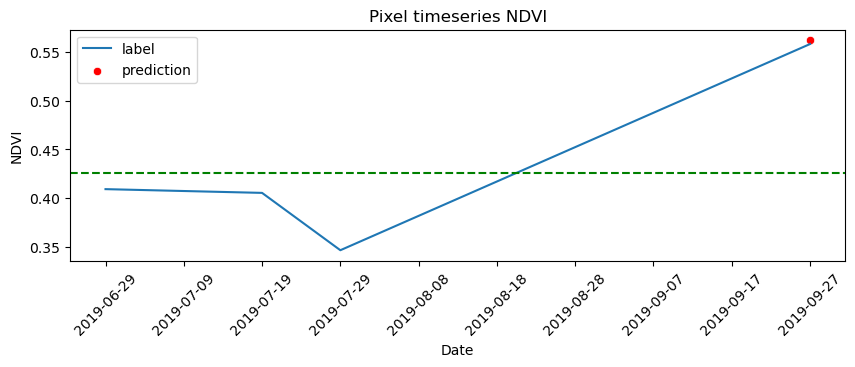

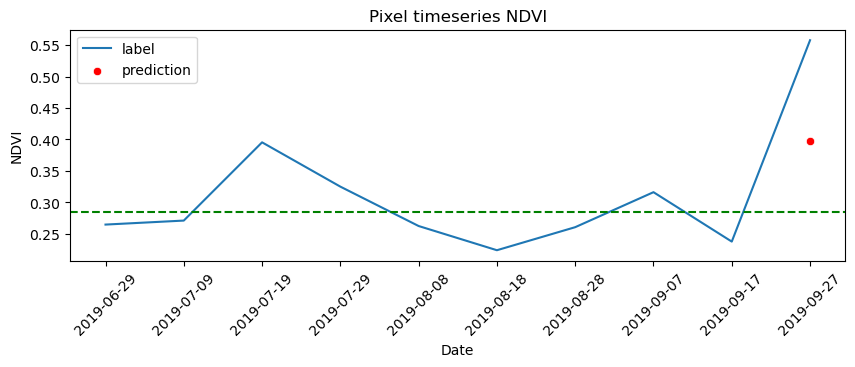

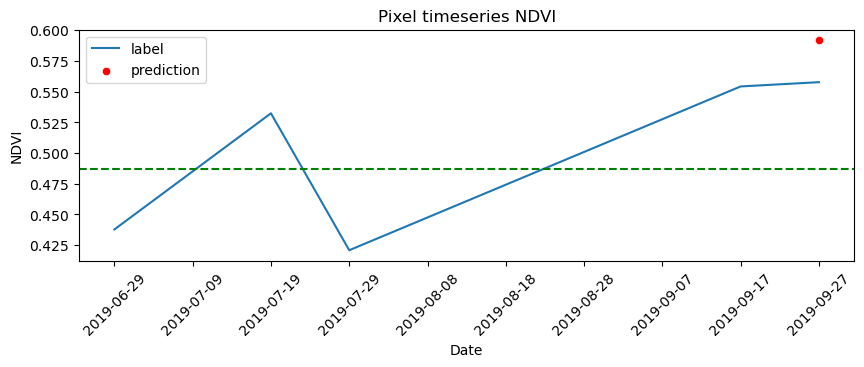

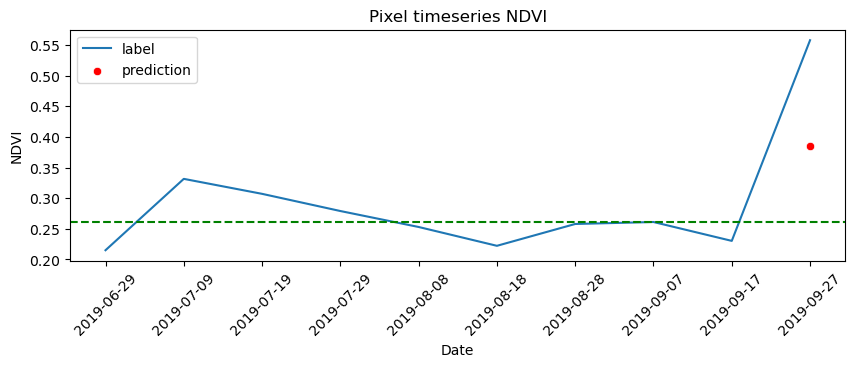

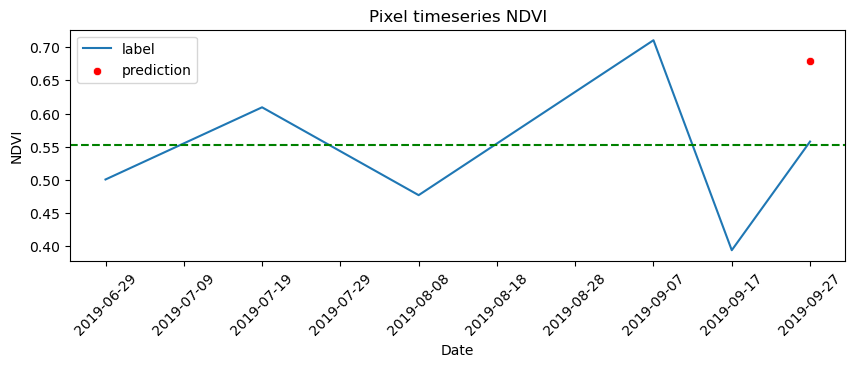

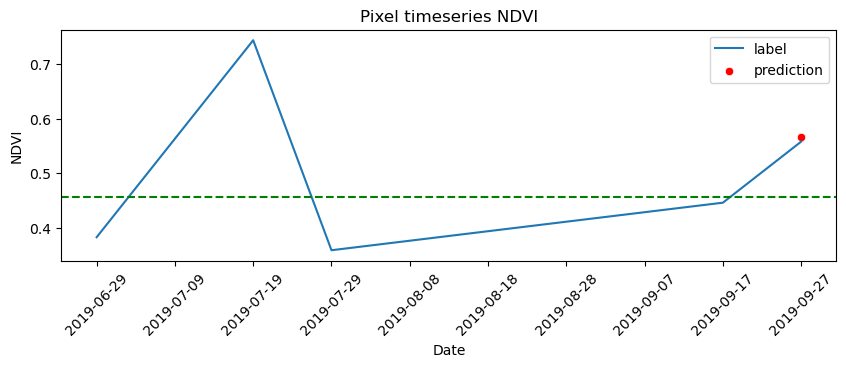

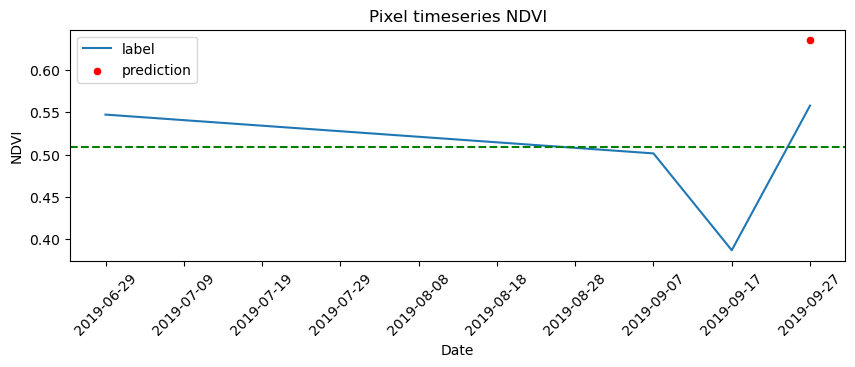

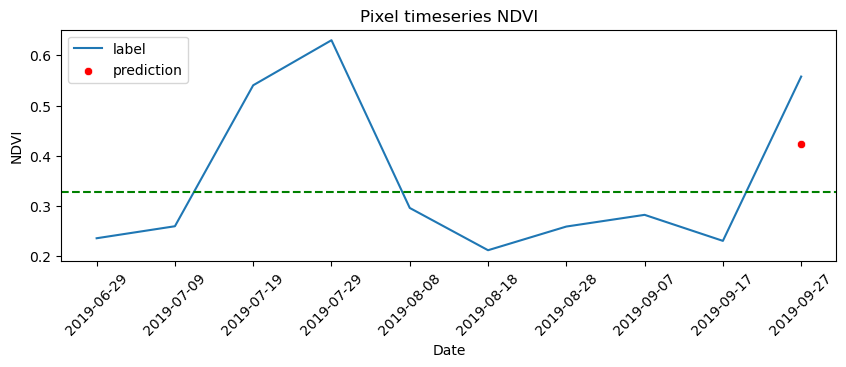

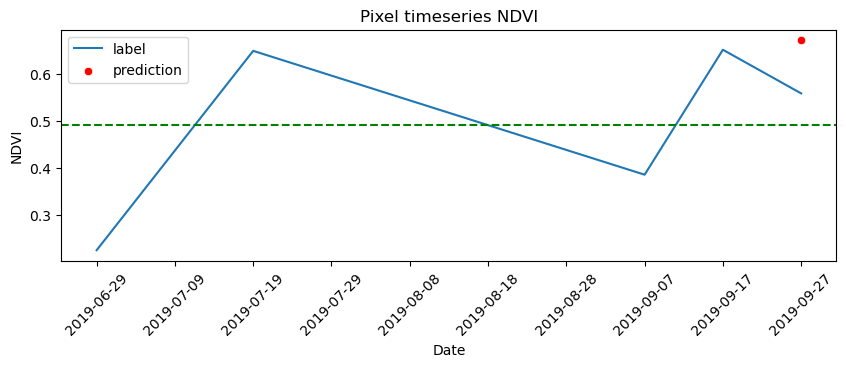

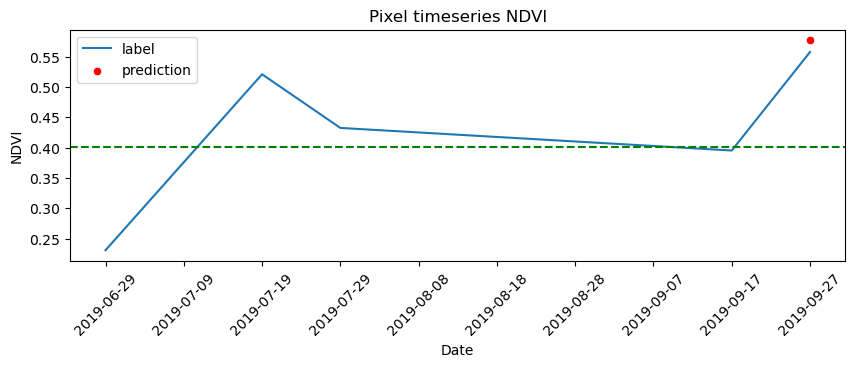

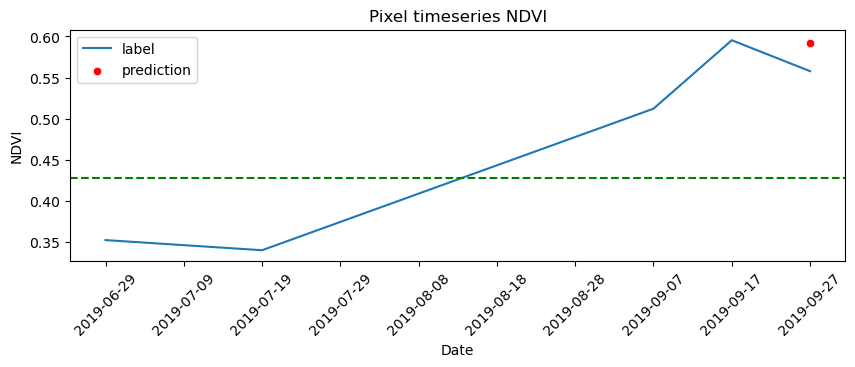

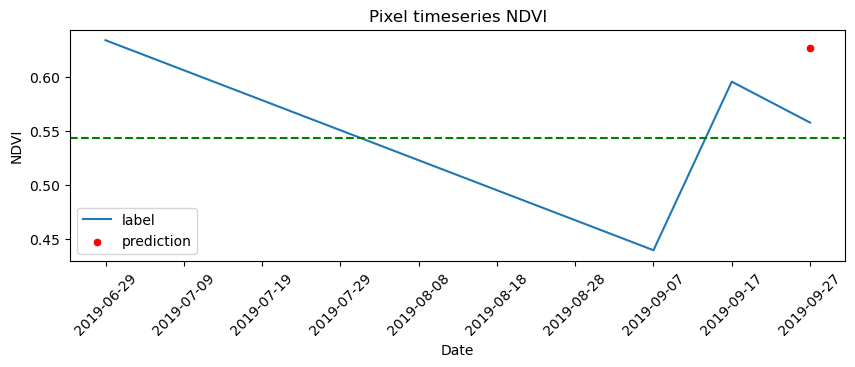

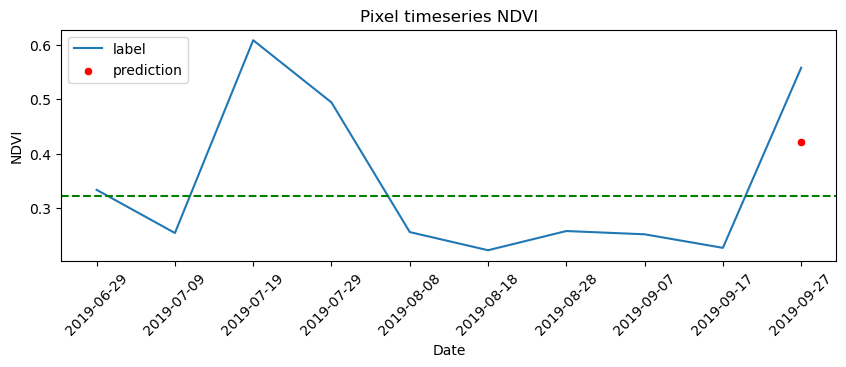

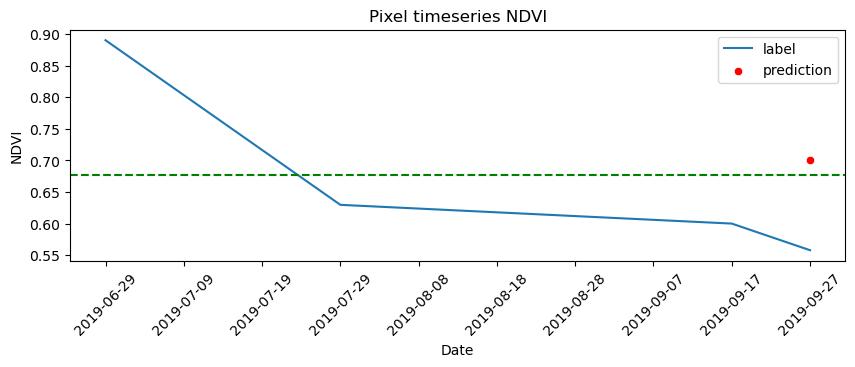

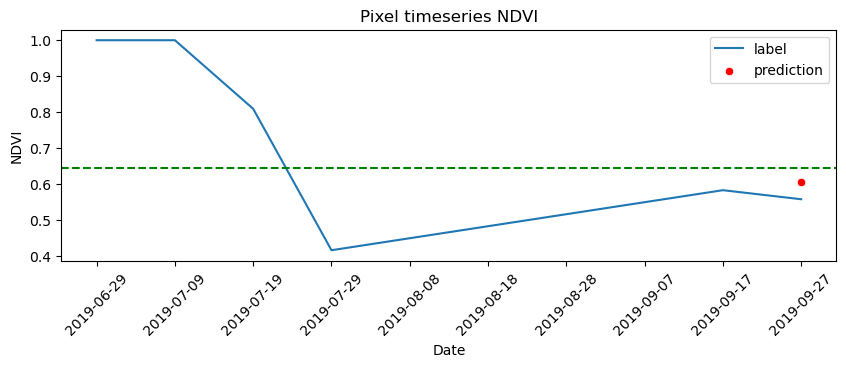

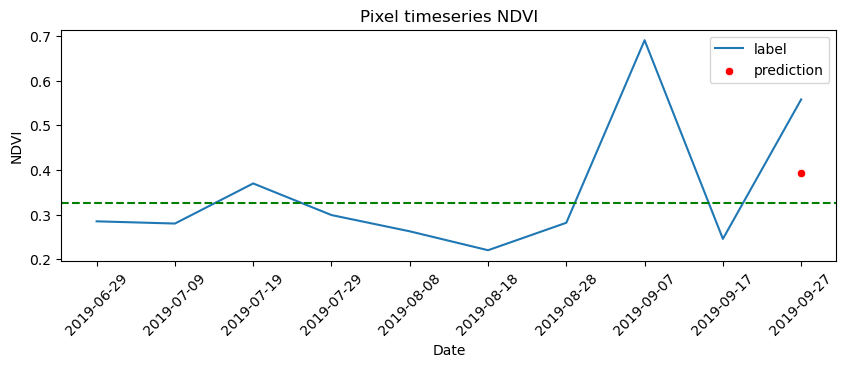

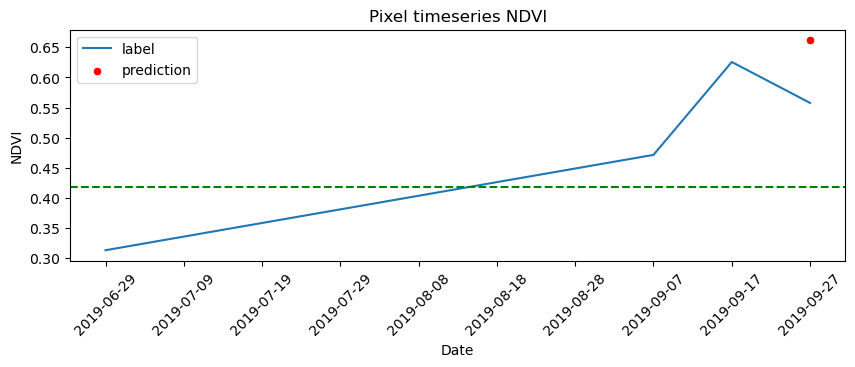

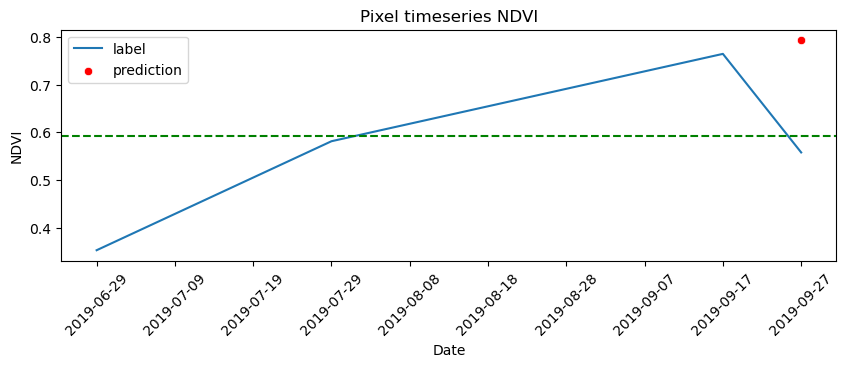

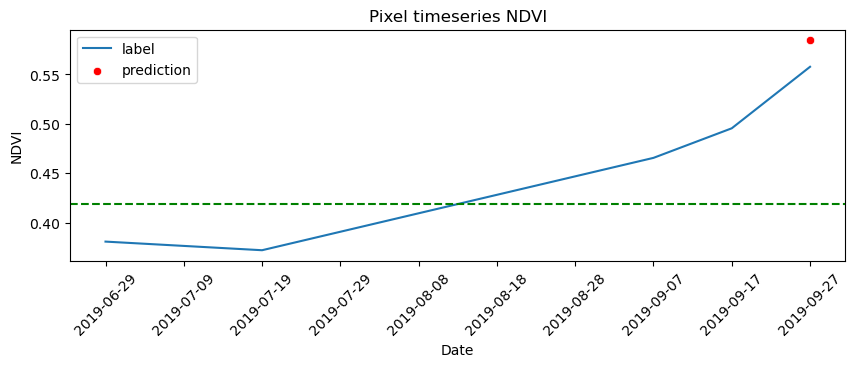

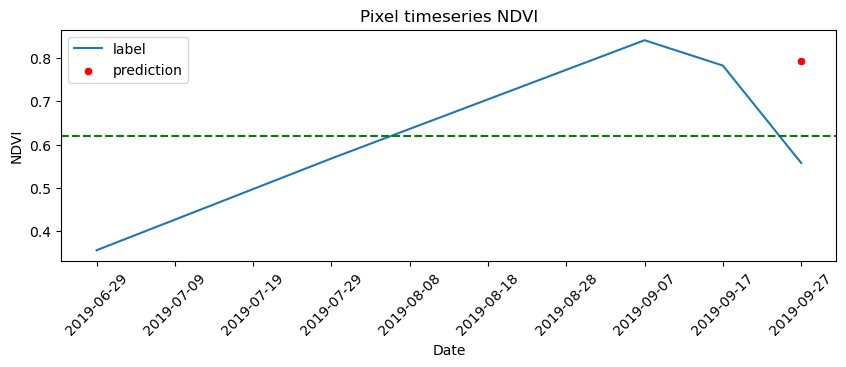

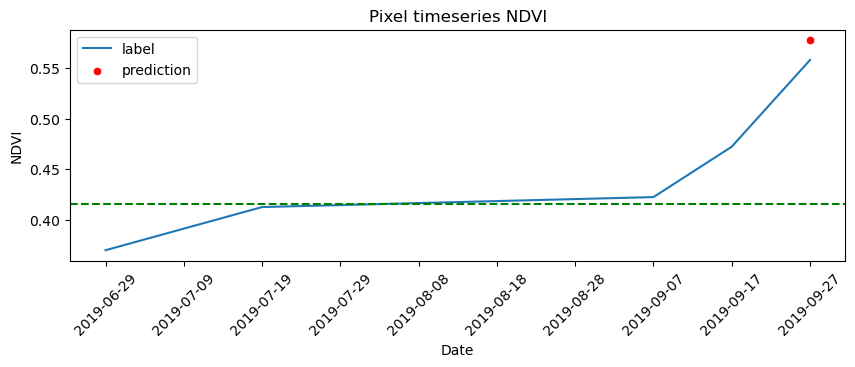

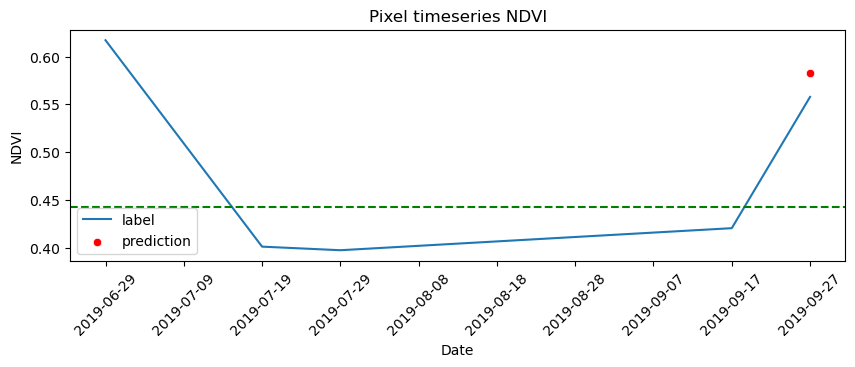

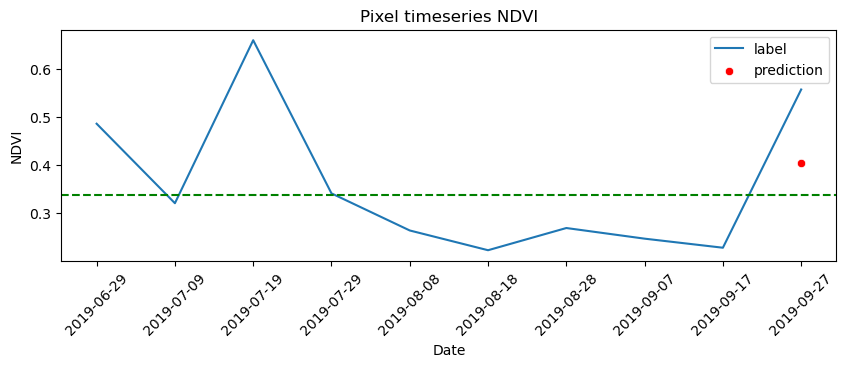

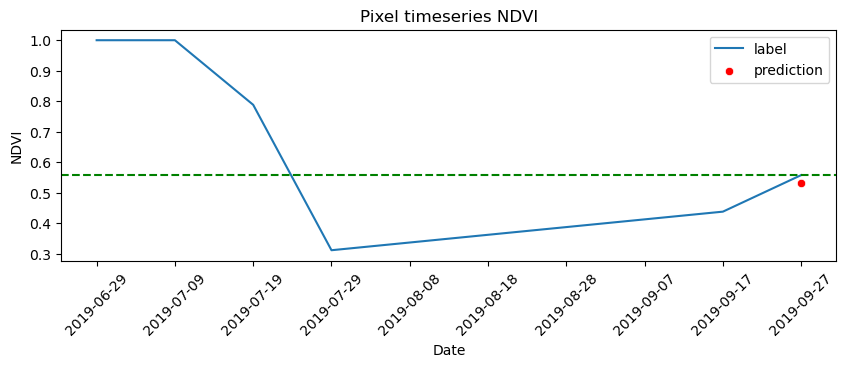

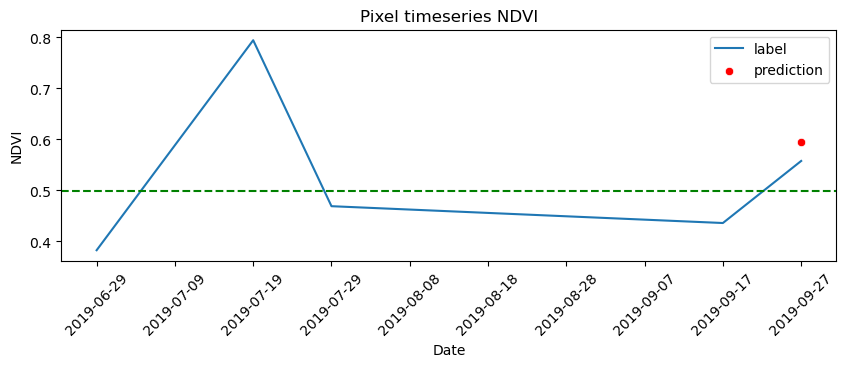

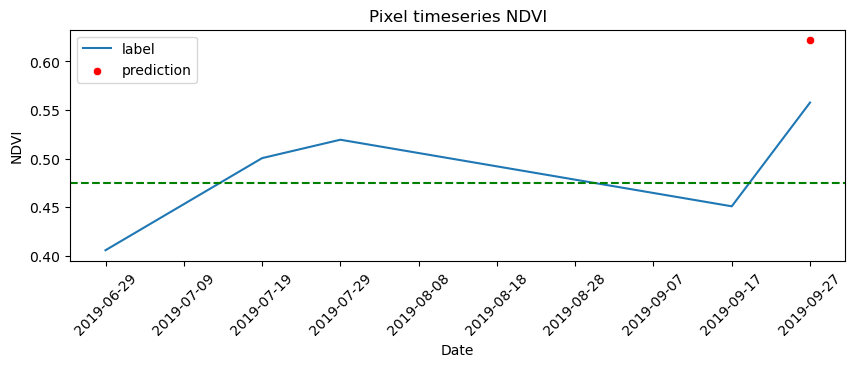

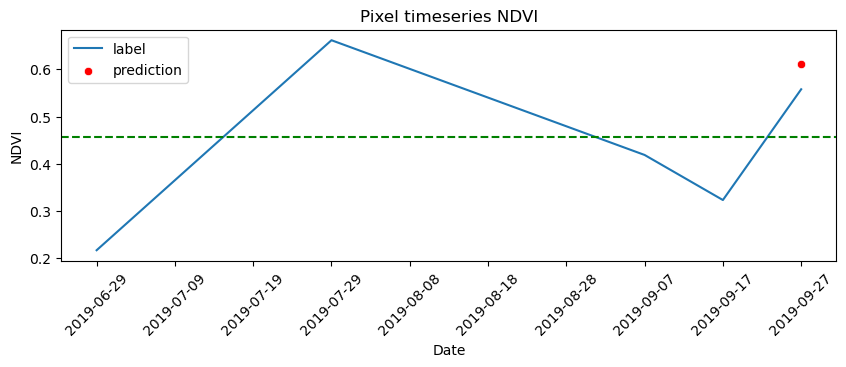

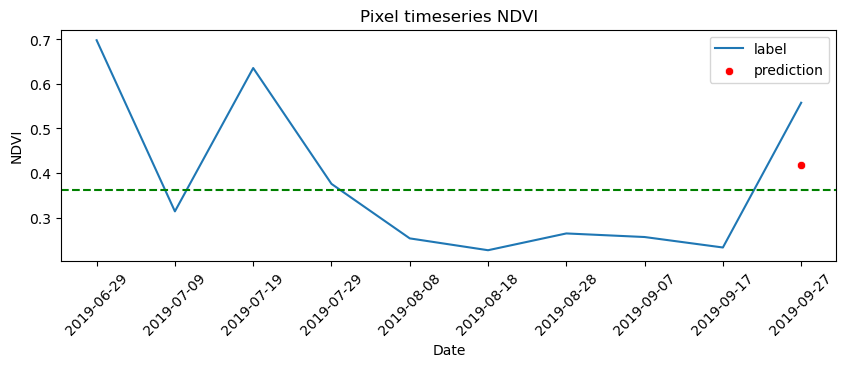

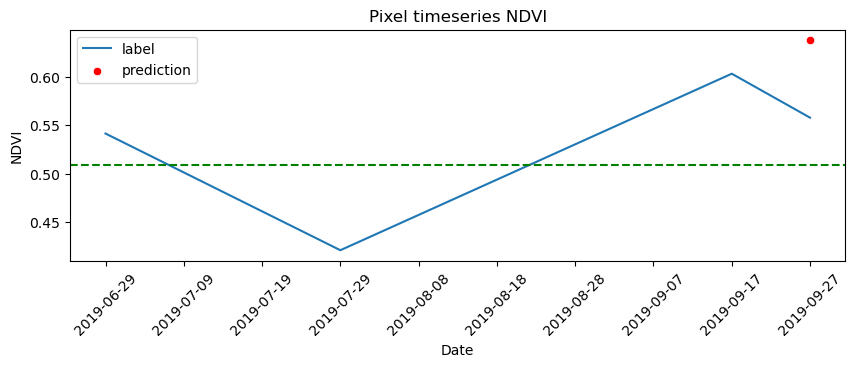

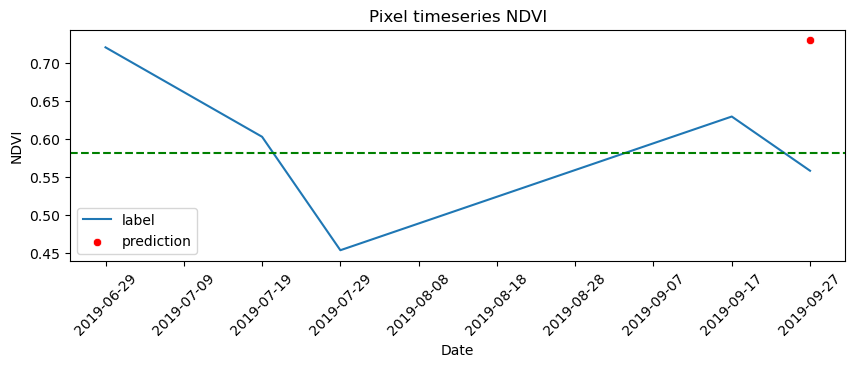

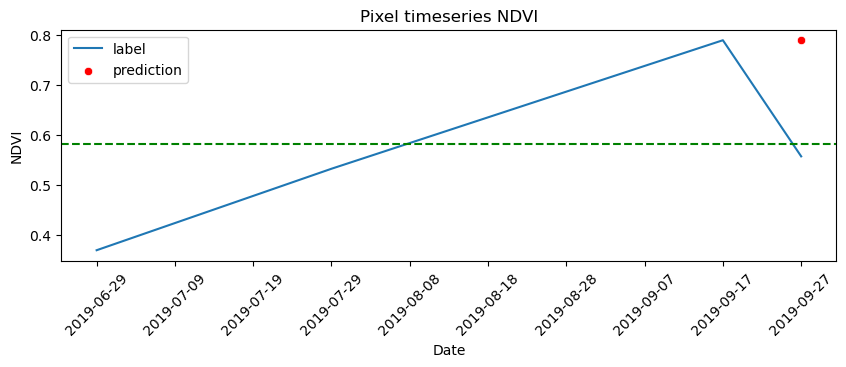

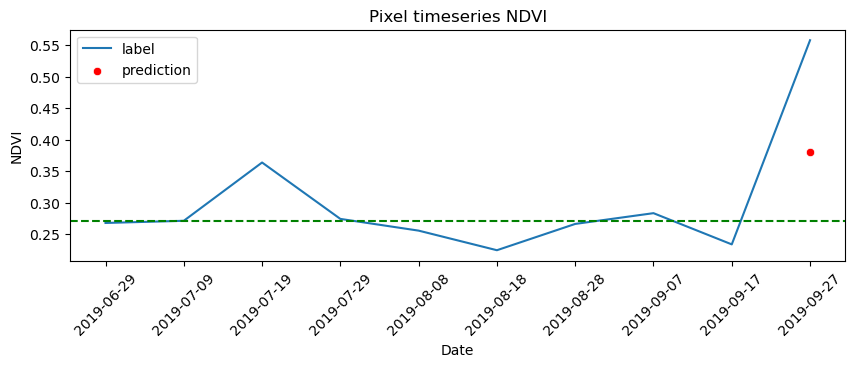

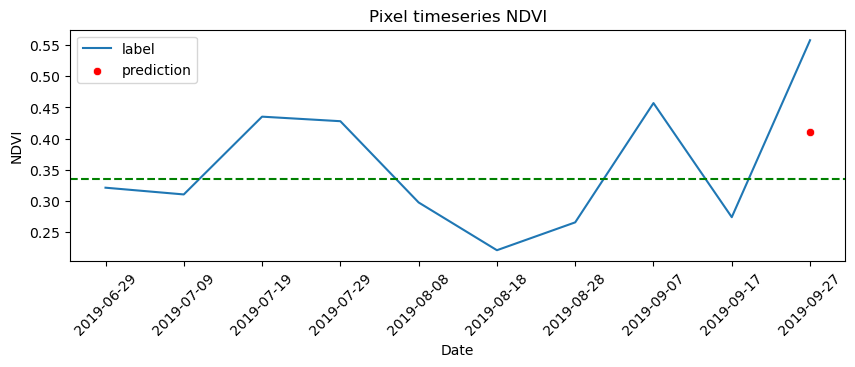

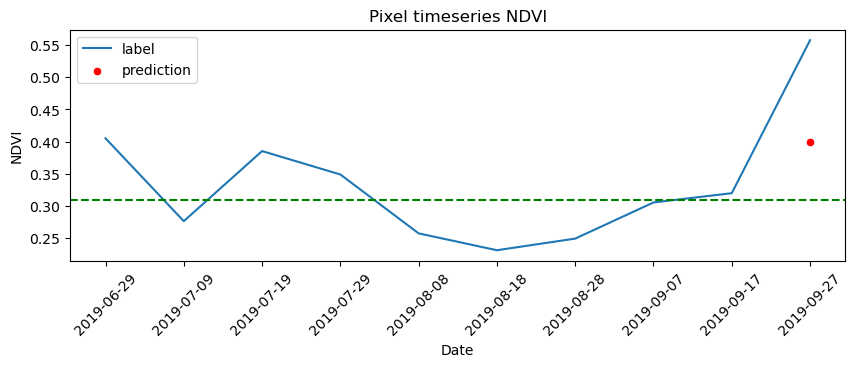

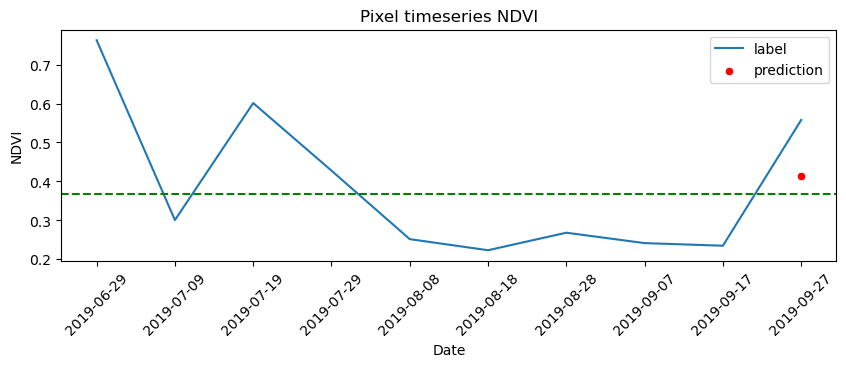

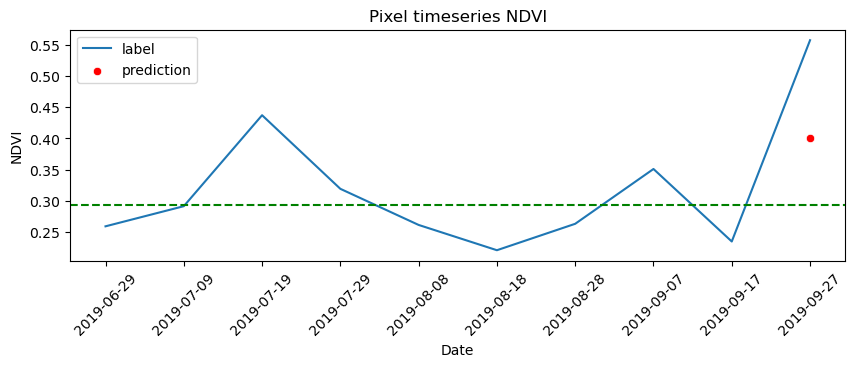

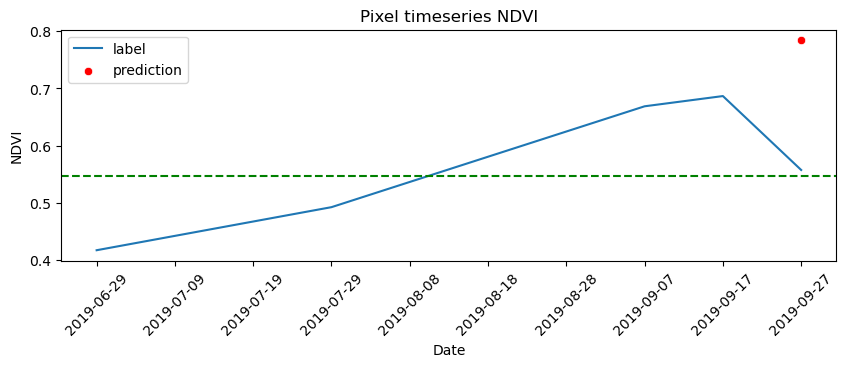

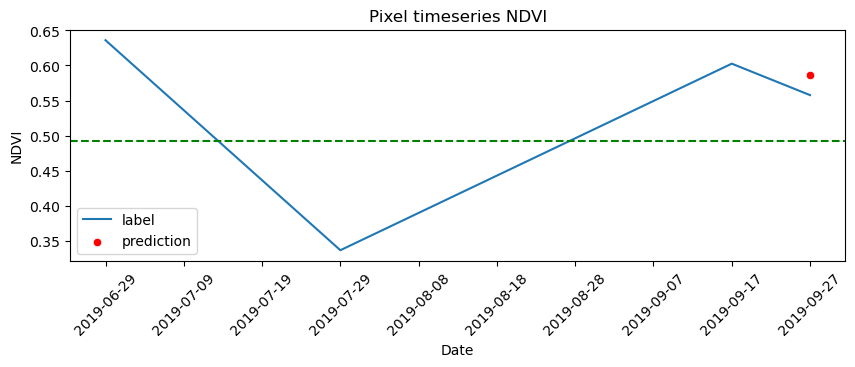

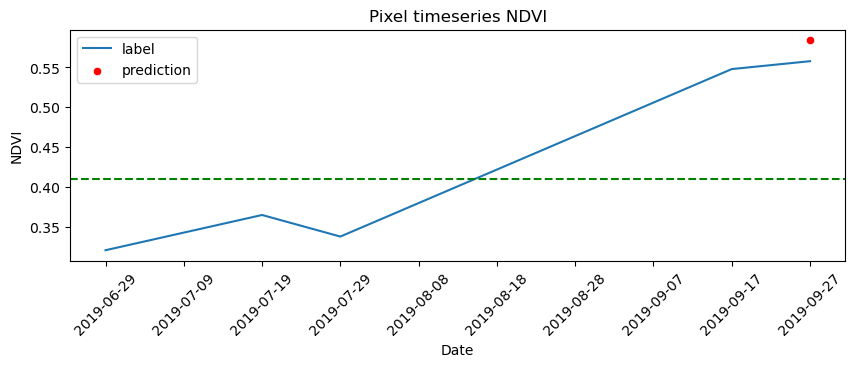

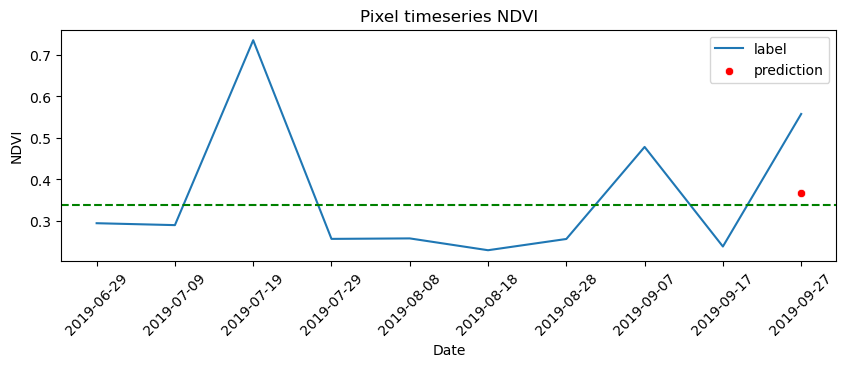

In [25]:
for sample_id in range(40):
    ndvi_input = img[sample_id, :, 1, :, :].squeeze(1).squeeze(1).numpy()
    ndvi_label = label[0, :, :, :].squeeze(1).squeeze(1).numpy()
    ndvi_cleaned = np.concatenate([ndvi_input, ndvi_label])
    dates = all_loc_dates[idx_start][1] + all_loc_dates[idx_start][3][:1]

    pix_pred = y_pred[sample_id]
    tensor_of_nans = th.full(ndvi_input.shape, float('nan')).numpy()
    pix_pred = np.concatenate([tensor_of_nans, [pix_pred]])

    fig, ax = plt.subplots(1,1,figsize=(10,3))
    plt.title('Pixel timeseries NDVI')
    sns.lineplot(ax=ax, y=ndvi_cleaned, x=dates,label='label')
    # add dot of predicted NDVI 
    sns.scatterplot(ax=ax, y=pix_pred, x=dates,label='prediction', color='red')
    plt.axhline(y=ndvi_input.mean(), color = 'g', linestyle = '--', label='data mean')
    plt.xlabel('Date')
    plt.ylabel('NDVI')
    plt.xticks(rotation=45)